In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import FinanceDataReader as fdr

# 시각화 사용자 설정
from matplotlib import rcParams
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance as xgb_plot_importance
from lightgbm import plot_importance as lgb_plot_importance

from sklearn.decomposition import PCA
import joblib
import time

In [10]:
def graph(df, cols, axv_list=[]) :
    rcParams['figure.figsize'] = 11.7,8.27
    ax = sns.lineplot(data=df[cols])
    
    plt.title('compare : ' + (', '.join(cols)), fontsize=20)
    plt.ylabel('Value', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.legend(fontsize=12, loc='best')
    
    if axv_list != [] :
        for i in axv_list :
            if len(i) == 4 :
                color = i[3]
            else :
                color = 'b'
            plt.axvline(x=datetime(i[0], i[1], i[2]), color=color, linestyle='--', linewidth=1)

    plt.show()
    return

### 이진분류 머신러닝 / MLP 함수 정의

In [11]:
def machineLearning_Classifier(X_train, y_train, X_test, y_test, modelSave=False) :
    neighbor_model = KNeighborsClassifier(n_neighbors=5)
    svm_model = SVC()
    forest_model = RandomForestClassifier(n_estimators=300)
    gbm_model = GradientBoostingClassifier(random_state=10)
    xgb_model = XGBClassifier(n_estimators=300, eval_metric = "logloss")
    lgb_model = LGBMClassifier(n_estimators=300)

    model_list = [neighbor_model, svm_model, forest_model, gbm_model, xgb_model, lgb_model]

    for model in model_list:
        model_name = model.__class__.__name__
        model.fit(X_train , y_train)
        print('\n{0} 학습데이터셋 정확도: {1:.4f}'.format(model_name, model.score(X_train , y_train)))

        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)    
        print('{0} 테스트셋 정확도: {1:.4f}'.format(model_name, accuracy)) 
        
        if modelSave :
            joblib.dump(model, model_name+'.pkl')
    print()
    return model_list

def xgb_FeatureImportance(xgb_model) :
    print('-------------XGB Plot Importance-------------')
    plt.rc('font', family='NanumGothic') # For Windows
    fig, ax = plt.subplots(figsize=(10, 12))
    xgb_plot_importance(xgb_model, ax=ax)
    plt.show()
    return

def lgb_FeatureImportance(lgb_model) :
    print('-------------LGB Plot Importance-------------')
    plt.rc('font', family='NanumGothic') # For Windows
    fig, ax = plt.subplots(figsize=(10, 12))
    lgb_plot_importance(lgb_model, ax=ax)
    plt.show()
    return

def rf_FeatureImportance(forest_model, columns) :
    print('-------------FOREST Plot Importance-------------')
    plt.rc('font', family='NanumGothic') # For Windows
    features = columns
    importances = forest_model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots(figsize=(10, 12))
    plt.title('RandomForest Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return

def MLP_Classifier(input_dim, X_train, y_train, X_test, y_test, modelSave=False) :
    model = Sequential()
    model.add(Dense(60, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=10)
    
    eval = model.evaluate(X_test, y_test)
    print('{0} 정확도: {1:.4f}, Loss: {2:.4f}'.format(model.__class__.__name__, eval[1], eval[0]))
    if modelSave :
        model.save(model.__class__.__name__+'.h5')
    return model

### 회귀 머신러닝 / 딥러닝 함수 정의

In [12]:
def mse(y, pred):
    squared_error = (y - pred) ** 2
    mse = np.mean(squared_error)
    print('MSE: {0:.8f}'.format(mse))
    return mse

def machineLearning_Regression(X_train, y_train, X_test, y_test, drawGraph=True) :
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=500)
    gbm_model = GradientBoostingRegressor(n_estimators=500)
    xgb_model = XGBRegressor(n_estimators=500)
    lgbm_model = LGBMRegressor(n_estimators=500)

    model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
    for model in model_list:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        print('###',model.__class__.__name__,'###')
        mse(y_test, pred)
        if drawGraph :
            tmpDf = pd.DataFrame(index=X_test.index)
            tmpDf['pred'] = pred
            tmpDf['y_test'] = y_test
            graph(tmpDf, tmpDf.columns.tolist())
    return model_list

def plotFeatureList(model, X):
    coef = pd.Series(model.coef_, index=X.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    return

def MLP_Regression(input_dim, X_train, y_train, X_test, y_test, epochs=10, batch_size=10, drawGraph=True) :
    model = Sequential()
    model.add(Dense(60, input_dim= X_train.shape[1], activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                 metrics=['mse'])

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # 예측 값과 실제 값의 비교
    pred = model.predict(X_test).flatten()
    print('###',model.__class__.__name__,'###')
    mse(y_test, pred)    
    if drawGraph :
        tmpDf = pd.DataFrame(index=X_test.index)
        tmpDf['pred'] = pred
        tmpDf['y_test'] = y_test
        graph(tmpDf, tmpDf.columns.tolist())
    return model

### X, Y 정의 (이진분류)

In [13]:
df = pd.read_csv('./df.csv',  index_col=['Date'], parse_dates=True, encoding='euc-kr')

# Y
df['binClass'] = df.apply(lambda x : 1 if x['samsung'] > 0 else 0, axis=1)
df['binClass'] = df['binClass'].shift(-1)
df.dropna(inplace=True, axis=0)

Y = df['binClass']

# X
X = df.drop(['binClass'], axis=1,inplace=False)

n_components = 18 # 주성분을 몇개로 할지 결정
columns = ['PCA_'+str(x) for x in range(0, n_components)]

pca = PCA(n_components=n_components) 
pca_fit = pca.fit(X)
# pca 저장
joblib.dump(pca_fit, 'pca_fit_classifier.pkl')
printcipalComponents = pca_fit.transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = columns, index=X.index)
print(f'주성분 {n_components}개로 전체 데이터의 분산을 {str(sum(pca.explained_variance_ratio_)*100)}만큼 설명')

X_train, X_test, y_train, y_test = train_test_split(principalDf, Y, test_size=0.3, shuffle=False, random_state=0)

주성분 18개로 전체 데이터의 분산을 99.76520767034374만큼 설명


In [14]:
model_list = machineLearning_Classifier(X_train, y_train, X_test, y_test)


KNeighborsClassifier 학습데이터셋 정확도: 0.7179
KNeighborsClassifier 테스트셋 정확도: 0.5130

SVC 학습데이터셋 정확도: 0.7235
SVC 테스트셋 정확도: 0.6104

RandomForestClassifier 학습데이터셋 정확도: 1.0000
RandomForestClassifier 테스트셋 정확도: 0.5584

GradientBoostingClassifier 학습데이터셋 정확도: 1.0000
GradientBoostingClassifier 테스트셋 정확도: 0.5325

XGBClassifier 학습데이터셋 정확도: 1.0000
XGBClassifier 테스트셋 정확도: 0.5584

LGBMClassifier 학습데이터셋 정확도: 1.0000
LGBMClassifier 테스트셋 정확도: 0.5714



### train 과 test 비율 조정하여 재시도

In [15]:
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(principalDf, Y, test_size=test_ratio, shuffle=False, random_state=0)
model_list = machineLearning_Classifier(X_train, y_train, X_test, y_test, modelSave=True)


KNeighborsClassifier 학습데이터셋 정확도: 0.6993
KNeighborsClassifier 테스트셋 정확도: 0.5340

SVC 학습데이터셋 정확도: 0.7359
SVC 테스트셋 정확도: 0.6408

RandomForestClassifier 학습데이터셋 정확도: 1.0000
RandomForestClassifier 테스트셋 정확도: 0.6117

GradientBoostingClassifier 학습데이터셋 정확도: 0.9976
GradientBoostingClassifier 테스트셋 정확도: 0.6214

XGBClassifier 학습데이터셋 정확도: 1.0000
XGBClassifier 테스트셋 정확도: 0.6214

LGBMClassifier 학습데이터셋 정확도: 1.0000
LGBMClassifier 테스트셋 정확도: 0.6019



### KNN 으로 RandomSearch 하여 하이퍼파라미터 조정

In [16]:
'''
KNeighborsClassifier 학습데이터셋 정확도: 0.6923
KNeighborsClassifier 테스트셋 정확도: 0.5545
'''

k_range = list(range(1, 31))
#weight_options = ['uniform', 'distance']
#leaf_size = list(range(10, 50))
#p = [1, 2]
#algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

#param_grid = dict(n_neighbors=k_range, weights=weight_options, algorithm=algorithm, leaf_size=leaf_size, p=p)
param_grid = dict(n_neighbors=k_range)
kf = KFold(n_splits=10, shuffle=False)
knn = KNeighborsClassifier(n_neighbors=5)

random = RandomizedSearchCV(
        estimator=knn,
        param_distributions = param_grid,
        n_iter = 30,
        cv = kf,
        scoring = 'accuracy')
random.fit(X_train, y_train)
#random.fit(principalDf, Y)

print('최적 하이퍼 파라미터:\n', random.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(random.best_score_))

train_preds = random.predict(X_train)
test_preds  = random.predict(X_test)

print(' 훈련 정확도: {0:.4}'.format(round(accuracy_score(y_train, train_preds), 4)), "\n",
      '시험 정확도: {0:.4}'.format(round(accuracy_score(y_test,  test_preds), 4)), )

최적 하이퍼 파라미터:
 {'n_neighbors': 3}
최고 예측 정확도: 0.5404
 훈련 정확도: 0.7677 
 시험 정확도: 0.5437


In [17]:
neighbor_model = KNeighborsClassifier(n_neighbors=3)
neighbor_model.fit(X_train , y_train)
print('\n학습데이터셋 정확도: {0:.4f}'.format(neighbor_model.score(X_train , y_train)))
pred = neighbor_model.predict(X_test)
accuracy = accuracy_score(y_test, pred)    
print('테스트셋 정확도: {0:.4f}'.format(accuracy))


학습데이터셋 정확도: 0.7677
테스트셋 정확도: 0.5437


### SVC RandomizedSearch

In [18]:
'''
SVC 학습데이터셋 정확도: 0.7320
SVC 테스트셋 정확도: 0.6733
'''
c_range = [0.1,1, 10, 100]
kernel = ['rbf', 'poly', 'sigmoid']
param_grid = {'C':c_range, 'kernel': kernel}
kf = KFold(n_splits=10, shuffle=False)
svc = SVC()

random = RandomizedSearchCV(
        estimator=svc,
        param_distributions = param_grid,
        n_iter = 10,
        cv = kf,
        scoring = 'accuracy',)
random.fit(X_train, y_train)
#random.fit(principalDf, Y)

print('최적 하이퍼 파라미터:\n', random.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(random.best_score_))

train_preds = random.predict(X_train)
test_preds  = random.predict(X_test)

print(' 훈련 정확도: {0:.4}'.format(round(accuracy_score(y_train, train_preds), 4)), "\n",
      '시험 정확도: {0:.4}'.format(round(accuracy_score(y_test,  test_preds), 4)), )

최적 하이퍼 파라미터:
 {'kernel': 'sigmoid', 'C': 1}
최고 예측 정확도: 0.5795
 훈련 정확도: 0.5575 
 시험 정확도: 0.6214


### Voting 모델

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
# VotingClassifier
from sklearn.ensemble import VotingClassifier

models = [
    ('ada', AdaBoostClassifier()),
    ('bc', BaggingClassifier()),
    ('etc',ExtraTreesClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC(probability=True)),
    ('xgb', XGBClassifier(eval_metric = "logloss")),
    ('lgbm', LGBMClassifier()),
    ('dtc', DecisionTreeClassifier()),
    ('lr', LogisticRegressionCV())
]

# hard vote
hard_vote  = VotingClassifier(models, voting='hard')
hard_vote.fit(X_train, y_train)
pred = hard_vote.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('VotingClassifier(hard) 정확도: {0:.4f}'.format(accuracy))

# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
soft_vote.fit(X_train, y_train)
pred = soft_vote.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('VotingClassifier(soft) 정확도: {0:.4f}'.format(accuracy))

joblib.dump(hard_vote, "VotingClassifier_hard"+'.pkl')
joblib.dump(soft_vote, "VotingClassifier_soft"+'.pkl')

VotingClassifier(hard) 정확도: 0.6893
VotingClassifier(soft) 정확도: 0.6505


['VotingClassifier_soft.pkl']

### MLP 모델

In [20]:
model = MLP_Classifier(len(principalDf.columns), X_train, y_train, X_test, y_test, modelSave=True)

Epoch 1/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4694
Epoch 2/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.5501
Epoch 3/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5428
Epoch 4/10
41/41 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5477
Epoch 5/10
41/41 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5306: 0s - loss: 0.6850 - accuracy: 0.
Epoch 6/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6869 - accuracy: 0.5403
Epoch 7/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6850 - accuracy: 0.5550
Epoch 8/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6833 - accuracy: 0.5550
Epoch 9/10
41/41 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.5844
Epoch 10/10
4/4 [==============================] - 0s 1ms/step - loss: 0.6812 - accu

### X, Y 정의 (회귀)

In [21]:
df = pd.read_csv('./df.csv',  index_col=['Date'], parse_dates=True, encoding='euc-kr')

# Y
df['predChange'] = df['samsung'].shift(-1)
df.dropna(inplace=True, axis=0)

Y = df['predChange']

# X

X = df.drop(['predChange'], axis=1,inplace=False)

n_components = 19
columns = ['PCA_'+str(x) for x in range(0, n_components)]

pca = PCA(n_components=n_components) 
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = columns, index=X.index)
print(f'주성분 {n_components}개로 전체 데이터의 분산을 {str(sum(pca.explained_variance_ratio_)*100)}만큼 설명\n')

X_train, X_test, y_train, y_test = train_test_split(principalDf, Y, test_size=0.3, shuffle=False, random_state=0)

# 기준선 : 매일 변화율의 평균으로 예측했을 때의 MSE
changeMean = y_test.mean()
print(f"y_test의 평균값({changeMean})으로 매일 예측했을 때의 MSE는 다음과 같다.")
mse(y_test, changeMean)
print("즉, 위 값보다 작은 MSE 가 나와야 함.\n")

model_list = machineLearning_Regression(X_train, y_train, X_test, y_test, drawGraph=False)

주성분 19개로 전체 데이터의 분산을 99.90307940319236만큼 설명

y_test의 평균값(0.0030646641358057494)으로 매일 예측했을 때의 MSE는 다음과 같다.
MSE: 0.00032094
즉, 위 값보다 작은 MSE 가 나와야 함.

### LinearRegression ###
MSE: 0.00053431
### RandomForestRegressor ###
MSE: 0.00029770
### GradientBoostingRegressor ###
MSE: 0.00037105
### XGBRegressor ###
MSE: 0.00034073
### LGBMRegressor ###
MSE: 0.00036963


### train 과 test 비율 조정하여 재시도

In [22]:
test_ratio = 0.29
X_train, X_test, y_train, y_test = train_test_split(principalDf, Y, test_size=test_ratio, shuffle=False, random_state=0)
model_list = machineLearning_Regression(X_train, y_train, X_test, y_test, drawGraph=False)

### LinearRegression ###
MSE: 0.00055102
### RandomForestRegressor ###
MSE: 0.00029995
### GradientBoostingRegressor ###
MSE: 0.00037623
### XGBRegressor ###
MSE: 0.00037830
### LGBMRegressor ###
MSE: 0.00036107


### Voting 모델

In [23]:
# VotingClassifier
from sklearn.ensemble import VotingRegressor
models = [
    ('gbc', GradientBoostingRegressor(n_estimators=500)),
    ('rfc', RandomForestRegressor(n_estimators=500)),
    ('xgb', XGBRegressor(n_estimators=500)),
    ('lgbm', LGBMRegressor(n_estimators=500)),
    ('lr', LinearRegression())
]

vote  = VotingRegressor(models)
vote.fit(X_train, y_train)
pred = vote.predict(X_test)
mseVal = mse(y_test, pred)
print('VotingClassifier MSE: {0:.8f}'.format(mseVal))

MSE: 0.00032871
VotingClassifier MSE: 0.00032871


### MLP 모델

Epoch 1/10
19/19 [==============================] - 0s 1ms/step - loss: 3.4555e-04 - mse: 3.4555e-04
Epoch 2/10
19/19 [==============================] - 0s 2ms/step - loss: 3.3503e-04 - mse: 3.3503e-04
Epoch 3/10
19/19 [==============================] - 0s 2ms/step - loss: 3.2564e-04 - mse: 3.2564e-04
Epoch 4/10
19/19 [==============================] - 0s 2ms/step - loss: 3.2213e-04 - mse: 3.2213e-04
Epoch 5/10
19/19 [==============================] - 0s 2ms/step - loss: 3.0421e-04 - mse: 3.0421e-04
Epoch 6/10
19/19 [==============================] - 0s 2ms/step - loss: 3.0459e-04 - mse: 3.0459e-04
Epoch 7/10
19/19 [==============================] - 0s 2ms/step - loss: 2.8098e-04 - mse: 2.8098e-04
Epoch 8/10
19/19 [==============================] - 0s 2ms/step - loss: 2.7600e-04 - mse: 2.7600e-04
Epoch 9/10
19/19 [==============================] - 0s 2ms/step - loss: 2.5912e-04 - mse: 2.5912e-04
Epoch 10/10
19/19 [==============================] - 0s 2ms/step - loss: 2.5496e-04 - mse: 

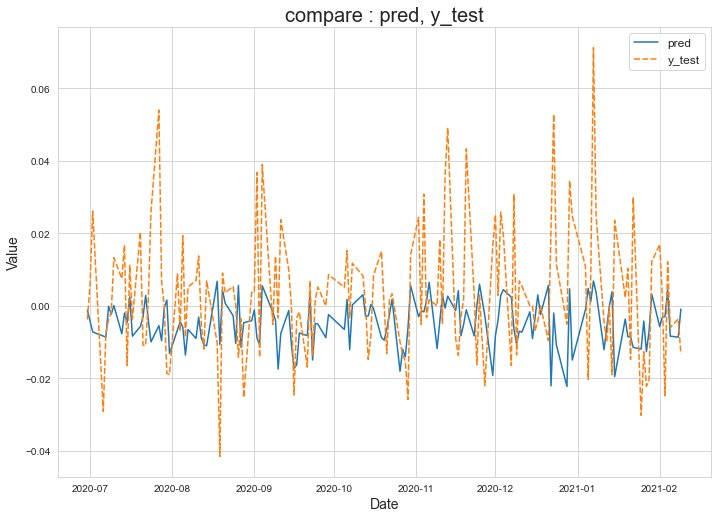

In [24]:
MLP_Regression(len(X.columns), X_train, y_train, X_test, y_test, epochs=10, batch_size=20)